## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

** (Semester 2, 2018) **

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset. 
    - Extended YaleB dataset. 
    - AR dataset (**optional**).
+ Perform Evaluation. 
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

Tutors: Fengxiang He, Nicholas James, Liu Liu, Zhuozhuo Tu, Baosheng Yu.

** Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html). **

## 1. Load Dataset

### 1.0 Data Folder

In [1]:
# The structure of data folder.
!ls -l data

total 0
drwxr-xr-x@ 41 geyang  staff  1312 Aug 29 15:39 CroppedYaleB
drwxr-xr-x@ 44 geyang  staff  1408 Aug 29 15:39 ORL


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [10]:
import os
import numpy as np
from PIL import Image

def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [11]:
# Load ORL dataset.
X, Y = load_data(root='data/ORL', reduce=2)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

# Load Extended YaleB dataset.
X, Y = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

ORL dataset: X.shape = (2576, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


In [12]:
root='data/CroppedYaleB'
person = sorted(os.listdir(root))[1]
reduce = 4
fname = os.listdir(os.path.join(root, person))[0]
img = Image.open(os.path.join(root, person, fname))
img = img.convert('L')
img = img.resize([s//reduce for s in img.size])
np.asarray(img).reshape(-1,1)

array([[255],
       [233],
       [238],
       ...,
       [  5],
       [  5],
       [  4]], dtype=uint8)

### 1.2 Load AR Dataset (Optional) 
AR dataset contains 2600 images of 100 individuals (50 male and 50 female). All images have been cropped and resized to 120x165 pixels. To further reduce the computation complexity, you can resize all images to 40x55 pixels.

In [5]:
def load_data_AR(root='data/CroppedAR', reduce=3):
    """ 
    Load AR dataset to numpy array.
    
    Args:
        root: path to AR dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []
    
    for fname in os.listdir(root):
        
        if not fname.endswith('.bmp'):
            continue
        
        # get label.
        label = int(fname[2:5])
        if fname[0] == 'W': # start from 50
            label += 50
        
        # load image.
        img = Image.open(os.path.join(root, fname))
        img = img.convert('L') # grey
        
        # reduce computation complexity.
        img = img.resize([s//reduce for s in img.size])
   
        # TODO: preprocessing.
        
        # convert image to numpy array.
        img = np.asarray(img).reshape((-1,1))
        
        # collect data and label.
        images.append(img)
        labels.append(label)
        
    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)
    
    return images, labels

In [6]:
# X, Y = load_data_AR(root='data/CroppedAR', reduce=3)
# print('AR dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

---------------------------


## 2. Evaluation Metrics


### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


In [70]:
# Standard NMF. From tutorial 6.
def mf_multiplicative_update(R, P, Q, steps=5000):
#     Q = Q.T
#     for step in range(steps):
#         Pu = P*(R.dot(Q.T))/(P.dot(Q).dot(Q.T))
#         Qu = Q*(P.T.dot(R))/(P.T.dot(P).dot(Q))
#         e_P = np.sqrt(np.sum((Pu-P)**2, axis=(0,1)))/P.size
#         e_Q = np.sqrt(np.sum((Qu-Q)**2, axis=(0,1)))/Q.size
#         if e_P<0.001 and e_Q<0.001:
#             print("step is:",step)
#             break
#         P = Pu
#         Q = Qu
#     return P, Q.T

    for step in range(steps):
        Pu = P*(R.dot(Q.T))/(P.dot(Q).dot(Q.T))
        Qu = Q*(P.T.dot(R))/(P.T.dot(P).dot(Q))
        
        e_P = np.sqrt(np.sum((Pu-P)**2, axis=(0,1)))/P.size
        e_Q = np.sqrt(np.sum((Qu-Q)**2, axis=(0,1)))/Q.size
        if e_P<0.001 and e_Q<0.001:
            print("step is:",step)
            break
        P = Pu
        Q = Qu
    return P, Q

==> Load ORL dataset ...
V_hat.shape=(1110, 400), Y_hat.shape=(400,)
==> Apply NMF ...


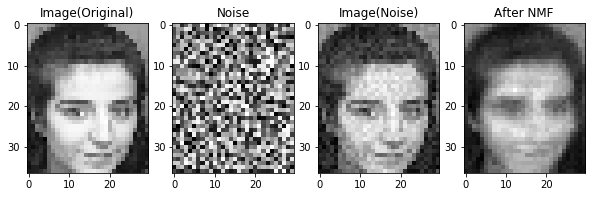

In [71]:
# Load dataset.
print('==> Load ORL dataset ...')
V_hat, Y_hat = load_data('data/ORL', reduce=3)
print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

# Add Noise.
V_noise = np.random.rand(*V_hat.shape) * 40
V = V_hat + V_noise

# Plot result.
import matplotlib.pyplot as plt
img_size = [i//3 for i in (92, 112)] # ORL

ind = 10 # index of demo image.

plt.figure(figsize=(10,3))
plt.subplot(141)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(142)
plt.imshow(V_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(143)
plt.imshow(V[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')
# plt.show()

# TODO: you should implement NMF algorithms by yourself.
print('==> Apply NMF ...')
# from sklearn.decomposition import NMF
# model = NMF(n_components=len(set(Y_hat))) # set n_components to num_classes.
# W = model.fit_transform(V)
# H = model.components_
# print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

N = V.shape[0]
M = V.shape[1]
K = len(set(Y_hat))
rng = np.random.RandomState(1)
P = rng.rand(N,K)
Q = rng.rand(K,M)

P_estimate, Q_estimate = mf_multiplicative_update(V, P, Q)

plt.subplot(144)
plt.imshow(P_estimate.dot(Q_estimate)[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('After NMF')
plt.show()

In [65]:
N = V.shape[0]
M = V.shape[1]
K = len(set(Y_hat))
print (N, " ", M, " ", K)

1110   400   40


In [67]:
print(P_estimate.shape)
print(Q_estimate.shape)
print('==> Evaluate RRE ...')
RRE = np.linalg.norm(V_hat - P_estimate.dot(Q_estimate)) / np.linalg.norm(V_hat)
print('RRE = {}'.format(RRE))

(1110, 40)
(40, 400)
==> Evaluate RRE ...
RRE = 0.9134552559814326


### 2.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [69]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

print('==> Evaluate Acc and NMI ...')

# Assign cluster labels.
Y_pred = assign_cluster_label(H.T, Y_hat)

acc = accuracy_score(Y_hat, Y_pred)
nmi = normalized_mutual_info_score(Y_hat, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))


==> Evaluate Acc and NMI ...
Acc(NMI) = 0.6125 (0.7578)
